# A Neural Algorithm of Artistic Style

_This notebook demonstrates the implementation of a neural algorithm proposed by  [Gatys et al., 2015](https://arxiv.org/pdf/1508.06576.pdf) for neural style transfer._


**Note**: The notebook has been derived from my previously written blog post ([link](https://jaygala24.github.io/blog/python/pytorch/neural-style/2020/07/31/neural-style-transfer.html)).


Neural Style Transfer is an algorithm developed by [Gatys et al., 2015](https://arxiv.org/pdf/1508.06576.pdf) that blends the content of one image with the style of another image using Deep Neural Networks to create artistic images of high perceptual quality.


## Intuition

Convolutional Neural Networks are very powerful, extracting the visual information hierarchically. This makes them really useful for this task. The lower layers care more about the detailed pixel values, whereas the higher layers care more about the actual content of the image (objects such as eyes, nose, etc.).


![cnn_layer_output](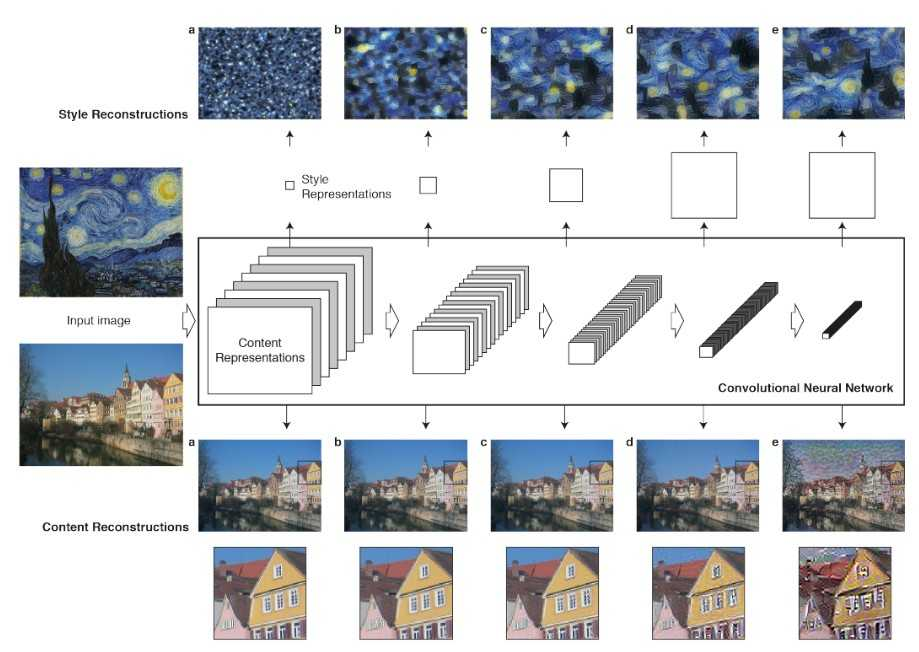 "CNN for Neural Style Transfer")

(source: https://arxiv.org/pdf/1508.06576.pdf)


The output image is a mix of two since we use the activations of the neural network at specific layers as a filter to get the intermediate style and content output of the inputs.

The principle underlying the neural style transfer is simple:
- Define two distances, one for the content and one for style.
- Measure how different the content and style are between two images, respectively.
- Reconstruct the image from white noise using backpropagation by minimizing both content and style distance with the content and style images, respectively.


## Objective

- Content loss
    $$L_{content}(\bar{p}, \bar{x}, \bar{l}) = \frac{1}{2}\sum_{i,j}(F_{ij}^l - P_{ij}^l)^2$$
    where,
    - $\bar{p}$ and $\bar{x}$ are the content and generated images respectively.
    - $F_{i,j}$ and $P_{i,j}$ are the feature representation of the original and generated image of $i^{th}$ filter at position $j$ in layer $l$ respectively.

- Style loss
    $$E_{l} = \frac{1}{4N_{l}^2M_{l}^2}\sum_{i,j}(G_{ij}^l - A_{ij}^l)^2$$
    $$L_{style}(\bar{a}, \bar{x}) = \sum_{i=0}^{L}w_{l}E_{l}$$
    where,
    - $\bar{a}$ and $\bar{x}$ are the style and generated image respectively.
    - $A^{l}$ and $G^{l}$ are the style representation (Gram Matrix) at layer $l$ respectively.
    - $w_{l}$ and $E_{l}$ are weighing factor and error for specific layer ${l}$ respectively.

- Total loss, which is a weighted sum of the two above
    $$L_{total}(\bar{p}, \bar{a}, \bar{x}) = \alpha L_{content}(\bar{p}, \bar{x}) + \beta L_{style}(\bar{a}, \bar{x})$$
    where,
    - $L_{content}$ and $L_{style}$ are the content and style loss respectively.
    - $\alpha$ and $\beta$ are weights for the content and style loss, respectively.
    - $\bar{p}$, $\bar{a}$ $\bar{x}$ are the content, style and generated images respectively.

There is a trade-off between the actual content and artistic style, which is determined by $\alpha$ and $\beta$. If the content is more important, then increase the $\alpha$. If the style is more important, then increase the $\beta$.


## Imports


In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Preprocessing and Loading


In [4]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

# VGG19 mean and std for each channel
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

loader = transforms.Compose([
    # scale imported image
    transforms.Resize(imsize),
    # transform it into a torch tensor
    transforms.ToTensor(),
    # normalize the tensor as per VGG network
    transforms.Normalize(mean=cnn_normalization_mean, 
                             std=cnn_normalization_std)
])

def load_image(image_path, transform=None):
    """
    Load an image and comvert it to a torch tensor.
    """
    image = Image.open(image_path)
    
    if transform:
        # transform the image
        image = transform(image)
        # add a fake batch dimension to fit network's input dimension
        image = image.unsqueeze(0)
    
    return image

In [5]:
# load the style and content image
style_img = load_image('./images/style.jpg', transform=loader).to(device)
content_img = load_image('./images/content.jpg', transform=loader).to(device)

In [6]:
def denorm_image(img_tensor):
    """
    Denormalize the image for visualization
    """
    # clone the image tensor and detach from tracking
    image = img_tensor.to('cpu').clone().detach()
    
    # remove the fake batch dimension
    image = image.numpy().squeeze()   
    # reshape (n_C, n_H, n_W) -> (n_H, n_W, n_C)
    image = image.transpose(1, 2, 0)

    # denormalize the image
    image = image * cnn_normalization_std.numpy() + cnn_normalization_mean.numpy()
    
    # restrict the value between 0 and 1 by clipping the outliers
    image = image.clip(0, 1)

    return image

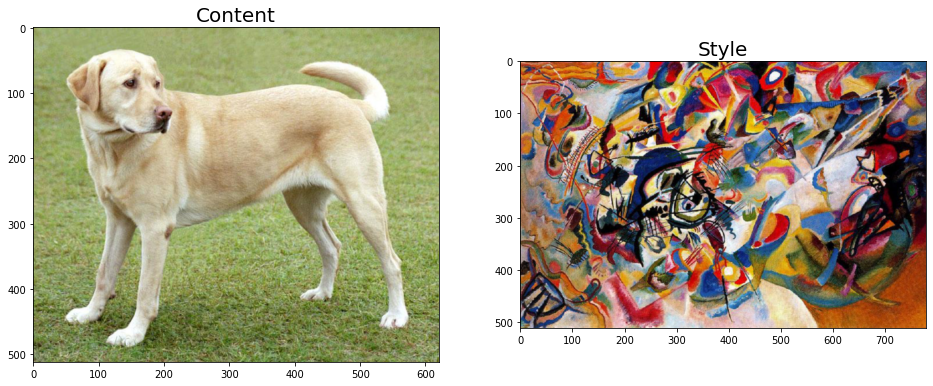

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
ax1.imshow(denorm_image(content_img))
ax1.set_title('Content', fontsize=20)
ax2.imshow(denorm_image(style_img))
ax2.set_title('Style', fontsize=20)
plt.show()

## CNN Model


In [3]:
# load the pretrained VGG19
vgg = models.vgg19(pretrained=True).features

# move the vgg model to GPU in eval mode (freeze model parameters) if available
vgg.to(device).eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [8]:
def get_feature_maps(image, model, layers=None):
    """
    Extract the convolutional feature maps from conv1_1 ~ conv5_1
    """
    if layers is None:
        # layer number for conv1_1 ~ conv5_1
        layers = ['0', '5', '10', '19', '28']
    
    # conv feature map
    features = []
    x = image
    
    # iterate through the model layers
    for name, layer in model._modules.items():
        x = layer(x)
        # checks for the layer match
        if name in layers:
            features.append(x)
    
    return features

In [9]:
def gram_matrix(input):
    """
    Calculates the gram matrix for input
    """
    # a = 1 (batch_size), b = n_C (number of feature maps)
    # (c, d) = dimension of feature map 
    a, b, c, d = input.size()

    # reshape the convolutional feature maps
    features = input.view(a * b, c * d)

    # compute the gram matrix
    G = torch.mm(features, features.t())

    # Normalize the values of gram matrix
    G = G.div(a * b * c * d)

    return G

In [10]:
target_img = content_img.clone().to(device)

# Alternative way: you can start with white noise to get an image with 
# content attributes of content image and style attributes of style image
# target_img = torch.randn(content_img.data.size()).to(device)

## Training and Inference


In [11]:
def run_neural_style_transfer(model, content_img, style_img, target_img, 
                              num_steps=2000, sample_steps=400, learning_rate=0.02,
                              style_weight=1e4, content_weight=1e-2):
    """
    Run the neural style transfer
    """
    # optimizer for reconstruction of content image with artistic style
    optimizer = torch.optim.Adam([target_img.requires_grad_()], lr=learning_rate, 
                                 betas=[0.99, 0.999])

    for step in range(num_steps):
        
        # extract the conv feature maps for target, content and style images
        target_features = get_feature_maps(target_img, model)
        content_features = get_feature_maps(content_img, model)
        style_features = get_feature_maps(style_img, model)
    
        # initialize the style and content loss
        style_loss = 0
        content_loss = 0

        # calculate the style and content loss for each specific layer
        for f1, f2, f3 in zip(target_features, content_features, style_features):

            # compute content loss with target and content images
            content_loss += torch.mean((f1 - f2) ** 2)

            # compute the gram matrix for target and style feature maps
            f1 = gram_matrix(f1)
            f3 = gram_matrix(f3)

            # compute the style loss with target and style images
            style_loss += torch.mean((f1 - f3) ** 2)
        
        # compute total loss, backprop and optimize
        loss = content_loss * content_weight + style_loss * style_weight
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if (step+1) % sample_steps == 0:
            # print the model stats
            print("run {}:".format(step+1))
            print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_loss.item(), content_loss.item()))
            print()

    return target_img

run 400:
Style Loss : 0.000006 Content Loss: 21.730204

run 800:
Style Loss : 0.000004 Content Loss: 19.803923

run 1200:
Style Loss : 0.000004 Content Loss: 19.264122

run 1600:
Style Loss : 0.000004 Content Loss: 19.008064

run 2000:
Style Loss : 0.000004 Content Loss: 18.843626



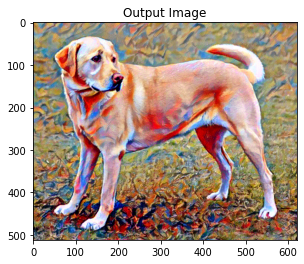

In [12]:
# run the neural style transfer
output_img = run_neural_style_transfer(vgg, content_img, style_img, target_img)

# display the style transfered image
output_img = denorm_image(output_img)

plt.figure()
plt.imshow(output_img)
plt.title('Output Image')
plt.show()

## References

- [Neural Style Transfer](https://arxiv.org/pdf/1508.06576.pdf)
- [Neural Style Transfer Using PyTorch](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)
